<a href="https://colab.research.google.com/github/Shifatasmiah/Medicine-Donation-/blob/main/MobileNetLarge_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import pathlib
import pickle
from sklearn.model_selection import KFold

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Diabetic Retinopathy/dataset'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

360


In [6]:
img_height, img_width = 224, 224
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 360 files belonging to 6 classes.


In [7]:
class_names = dataset.class_names
total_classes = len(class_names)
print(total_classes)
print(class_names)

6
['Hypertensive retinopathy', 'NO_DR 0', 'mild non proliferative retinoathy 1', 'moderate 2', 'proliferative DR 4', 'severe NPDR 3']


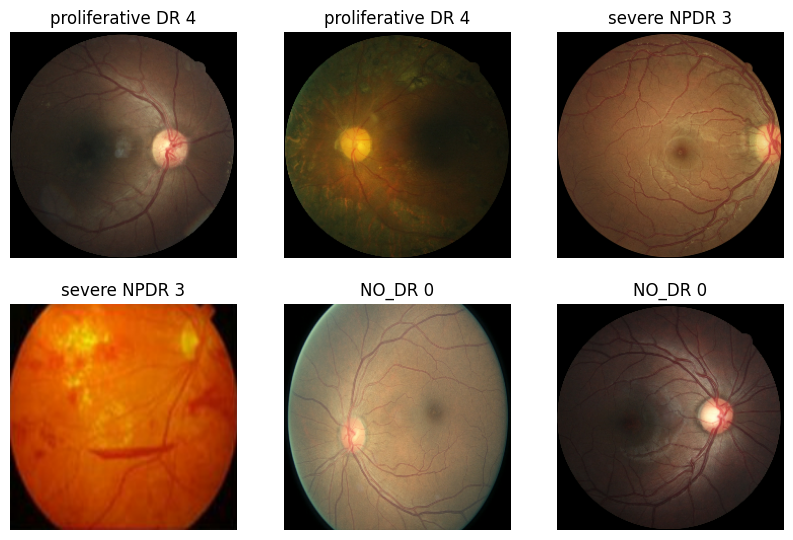

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [10]:
# convert it to one hot encoded
dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

In [11]:
# checkpoint and monitor val_accuracy val_precision val_recall val_f1_score
model_name = 'MobileNetV3Large'
checkpoint_filepath = '/content/drive/MyDrive/Diabetic Retinopathy/training_checkpoints/' + model_name + '.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    period=25
)

In [12]:
history_list = []
history_file = "/content/drive/MyDrive/Diabetic Retinopathy/training_history/" + model_name + ".pkl"
if os.path.exists(history_file):
    with open(history_file, "rb") as f:
        history_list = pickle.load(f)
else:
    history_list = []

In [13]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),

    ])

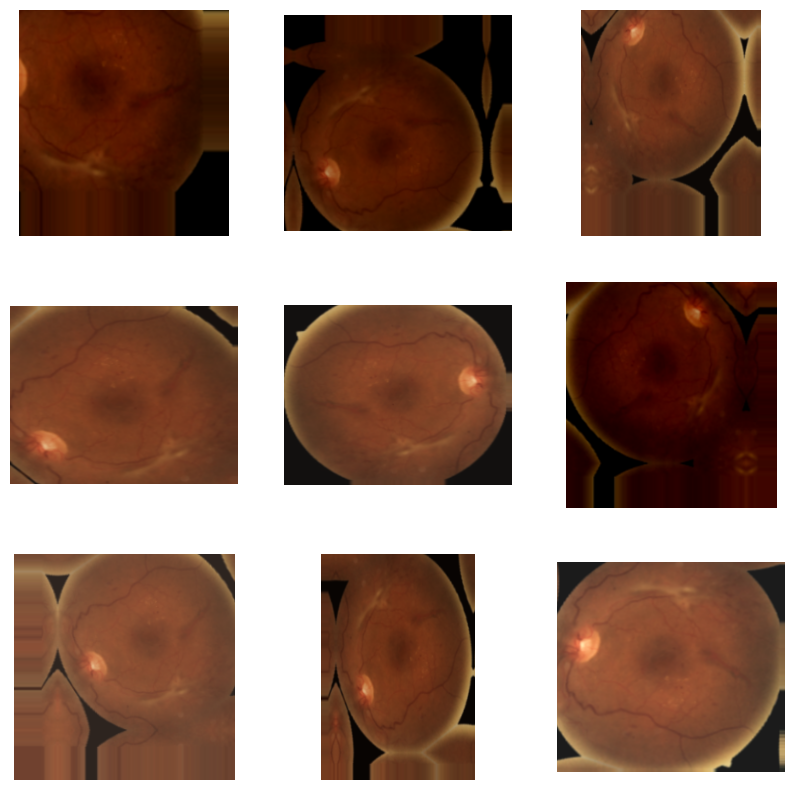

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[3].numpy().astype("uint8"))
        plt.axis("off")


In [15]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
if os.path.exists(checkpoint_filepath):
    # Load the model from the checkpoint file
    model = tf.keras.saving.load_model(checkpoint_filepath)
    print("Model loaded from checkpoint.")
else:
    pretrained_model = tf.keras.applications.MobileNetV3Large(include_top=False,
                                                            input_shape=(
                                                                img_height, img_width, 3),
                                                            pooling='avg', classes=total_classes,
                                                            weights='imagenet')

    for layer in pretrained_model.layers[:-10]:
        layer.trainable = False


    model = Sequential([
        data_augmentation,
        layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
        pretrained_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(total_classes, activation='softmax'),
    ])

    model.build((None, img_height, img_width, 3))

model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                                 
 dense_1 (Dense)             (None, 6)                 

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(total_classes,name = 'f1_score')
])

In [19]:
train_images = []
train_labels = []
for images, labels in dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

In [20]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

fold = 1
for train_index, val_index in kf.split(train_images):
    print(f"Training fold: {fold}")
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    train_fold = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_fold = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

    epochs = 100
    history = model.fit(
    train_fold,
    validation_data=val_fold,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    )

    fold += 1

    history_list.append(history.history)

with open(history_file, "wb") as f:
    pickle.dump(history_list, f)


Training fold: 1
Epoch 1/100
9/9 [==============================] - 25s 1s/step - loss: 1.9050 - accuracy: 0.3021 - precision: 0.3125 - recall: 0.1215 - f1_score: 0.2161 - val_loss: 1.5836 - val_accuracy: 0.4722 - val_precision: 0.5957 - val_recall: 0.3889 - val_f1_score: 0.2511
Epoch 2/100
9/9 [==============================] - 5s 527ms/step - loss: 1.3203 - accuracy: 0.4757 - precision: 0.6014 - recall: 0.2882 - f1_score: 0.3497 - val_loss: 1.5365 - val_accuracy: 0.4167 - val_precision: 0.5200 - val_recall: 0.3611 - val_f1_score: 0.2759
Epoch 3/100
9/9 [==============================] - 4s 481ms/step - loss: 1.0914 - accuracy: 0.5833 - precision: 0.7162 - recall: 0.3681 - f1_score: 0.5198 - val_loss: 1.7926 - val_accuracy: 0.4583 - val_precision: 0.4915 - val_recall: 0.4028 - val_f1_score: 0.3317
Epoch 4/100
9/9 [==============================] - 4s 429ms/step - loss: 0.9994 - accuracy: 0.6111 - precision: 0.7278 - recall: 0.4271 - f1_score: 0.6012 - val_loss: 2.0745 - val_accuracy: 

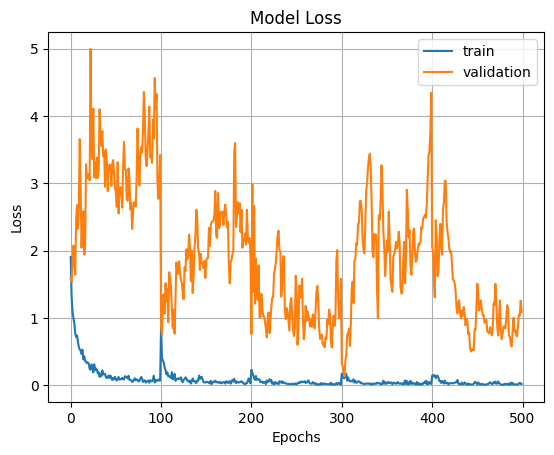

In [21]:
combined_history = {}
for metric in history_list[0].keys():
    combined_history[metric] = []
    for hist in history_list:
        combined_history[metric].extend(hist[metric])

# Plot the combined history
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

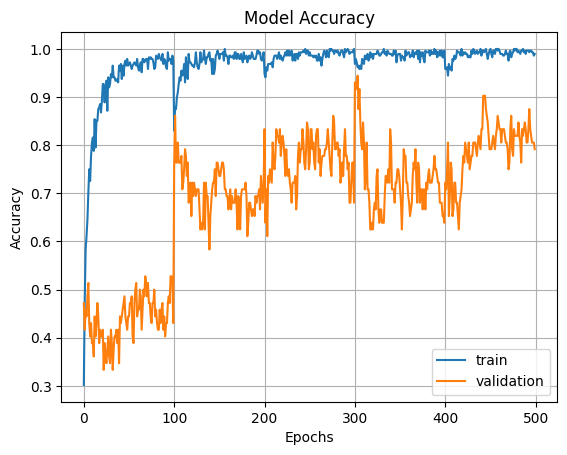

In [22]:
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

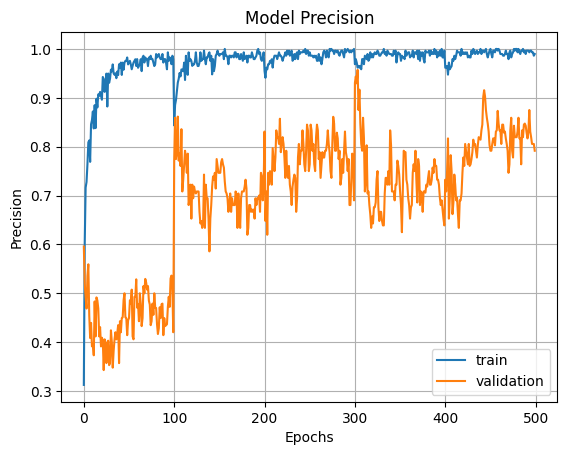

In [23]:
plt.plot(combined_history['precision'])
plt.plot(combined_history['val_precision'])
plt.grid()
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

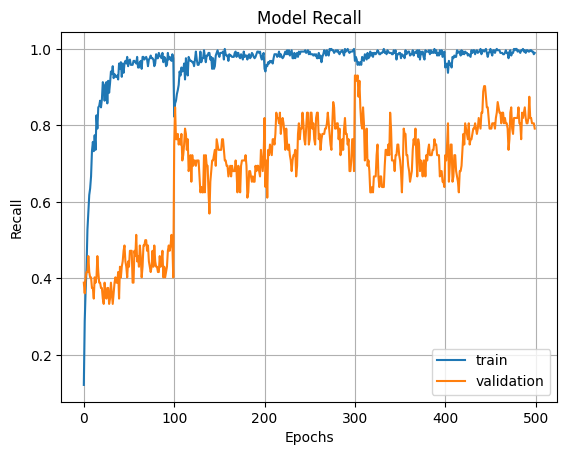

In [24]:
plt.plot(combined_history['recall'])
plt.plot(combined_history['val_recall'])
plt.grid()
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [25]:
import cv2

image = cv2.imread('/content/drive/MyDrive/Diabetic Retinopathy/dataset/proliferative DR 4/1138_right.jpg')
image_resized = cv2.resize(image, (img_height, img_width))
image = np.expand_dims(image_resized, axis=0)
print(image.shape)


(1, 224, 224, 3)


In [26]:
pred = model.predict(image)
print(pred)
# also print the probability of each class
print(np.max(pred))


1/1 [==============================] - 2s 2s/step
[[2.11891588e-10 1.51307304e-07 1.36741055e-05 9.26458895e-01
  7.35269114e-02 4.00646371e-07]]
0.9264589


In [27]:
output_class = class_names[np.argmax(pred)]
print("The predicted class is", output_class)


The predicted class is moderate 2
